In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

from ecomplexity import ecomplexity

**1 -- data preparation**

In [3]:
# data IN
data = pd.read_csv("../data/languages.csv")

In [4]:
# filter motivated by RM del Rio-Chanona et al 2023
prev_filter = "|".join(["yaml", "json", "text", "svg", "Markdown", "xml"])
df = data[~data["language"].str.contains(prev_filter, case=False, regex=True)]

# focus on TOP languages ONLY
top_languages = df.groupby(["language"])["num_pushers"].agg("sum").reset_index().sort_values(by="num_pushers", ascending=False)
top_languages = list(top_languages["language"])[:100]
df = df[df["language"].isin(top_languages)]

In [5]:
# baseline cleaning for the ecomplexity
df = df[df["year"]==2020]
df = df.groupby(["year", "iso2_code", "language"])["num_pushers"].agg("sum").reset_index().sort_values(by="num_pushers", ascending=False)
df = df[df["iso2_code"] != "EU"]

In [6]:
print(df.shape)

(5093, 4)


In [7]:
key_cols = {
    "time": "year",
    "loc": "iso2_code",
    "prod": "language",
    "val": "num_pushers",
}

cdf = ecomplexity(df, key_cols)

2020


In [8]:
cdf[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).head(10)

,eci,iso2_code
3325,2.059282,DE
2375,2.028812,CH
4370,1.991522,GB
11400,1.978975,SE
13110,1.974972,US
4275,1.963278,FR
9310,1.946025,NL
665,1.931133,AU
5985,1.897379,IT
2185,1.893506,CA


In [9]:
cdf[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).tail(10)

,eci,iso2_code
6935,-1.142078,LA
11875,-1.203049,SO
8740,-1.203049,MW
2090,-1.242559,BZ
1900,-1.242559,BW
1615,-1.242559,BN
7220,-1.242559,LR
1235,-1.242559,BF
950,-1.242559,BB
8645,-1.242559,MV


In [11]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).head(20)

,pci,language
46,2.638637,Mathematica
50,2.630674,Nix
25,2.626540,Gnuplot
47,2.589877,Meson
70,2.589809,SWIG
48,2.566328,NASL
21,2.559011,GAP
73,2.540781,Scheme
22,2.523715,GDB
19,2.522103,Fortran


In [12]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).tail(20)

,pci,language
7,0.144629,C#
75,0.089469,Shell
1,0.059983,ASP.NET
87,0.052540,TypeScript
62,-0.003527,Python
83,-0.232902,TSQL
38,-0.311553,Kotlin
39,-0.327332,Less
82,-0.370785,Swift
31,-0.475622,Hack


**2 -- visuals**


In [32]:
def mcl_raw_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')

    table = table\
            .sort_values(by=["total"], ascending=False, axis=0)\
            .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    table = np.log10(table)
    table.replace([np.inf, -np.inf], 0, inplace=True)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.tick_params("y", labelsize=size-9)
        ax.tick_params(left = False, bottom = False)

        my_cmap = plt.cm.get_cmap('Blues')
        colors = my_cmap(table.values.tolist())

        sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,table.values.max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, orientation="vertical", pad=0.1, shrink=0.9925, aspect=40, ax=ax)
        cbar.ax.set_ylabel("Number of pushers", size=size)
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.tick_params(labelsize=size-5)
        cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
        cbar.set_ticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'])

/opt/homebrew/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


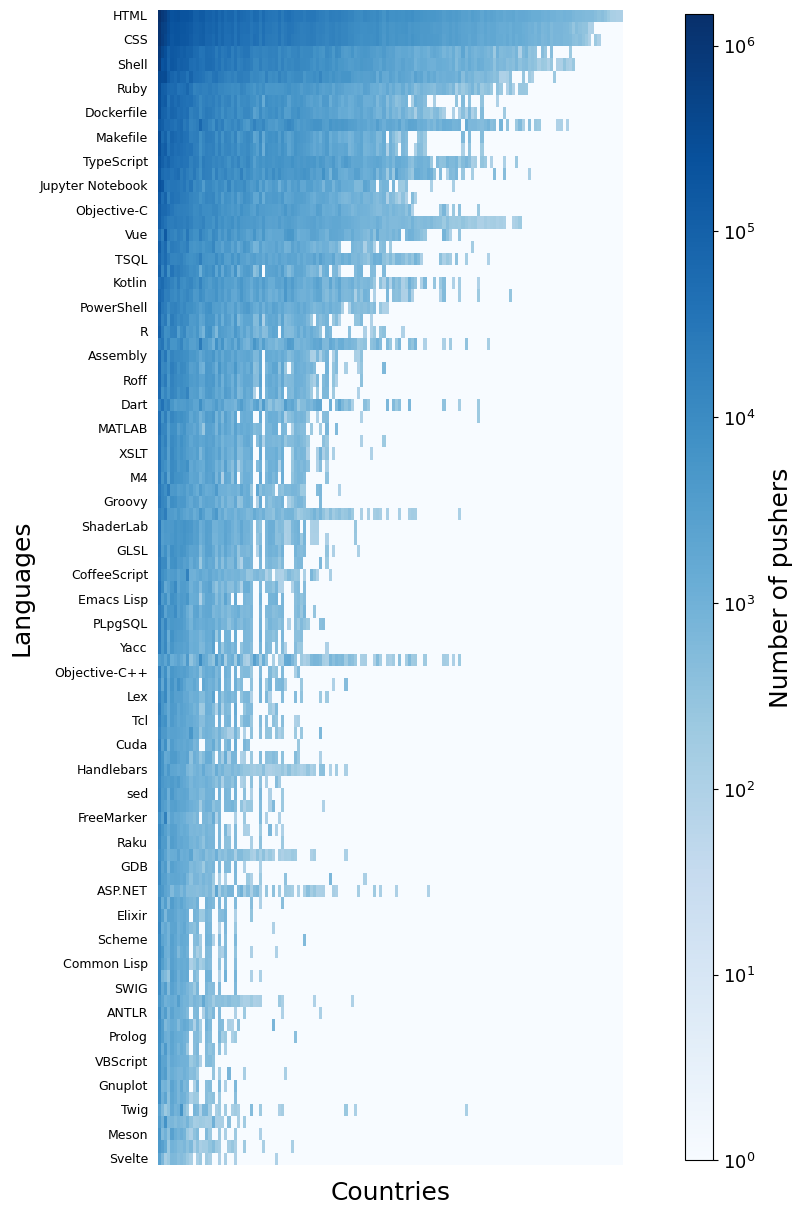

In [36]:
fig, ax = plt.subplots(1,1, figsize=(8, 15))
mcl_raw_matrix(cdf, key_columns=["iso2_code", "language", "num_pushers"], heatmap=True, size=18, ax=ax)

In [76]:
def mcl_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    table.loc[table[key_columns[2]] >=1, key_columns[2]] = 1
    table.loc[table[key_columns[2]] < 1, key_columns[2]] = 0
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')
    
    table = table\
        .sort_values(by=["total"], ascending=False, axis=0)\
        .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("RCA", size=size+2)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)
        

In [77]:
def mcc_matrix(df, key_columns, heatmap, size=18, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()

    mccp = np.dot(t_mat, mat)
    mccp = pd.DataFrame(mccp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).columns))

    if heatmap==False:
        return mccp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mccp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mcc' ", size=size)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Countries", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)


def mll_matrix(df, key_columns, heatmap, size, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()
    mllp = np.dot(mat, t_mat) 
    mllp = pd.DataFrame(mllp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).index))

    if heatmap==False:
        return mllp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mllp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mll' ", size=size+2)
        ax.set_xlabel("Languages", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)



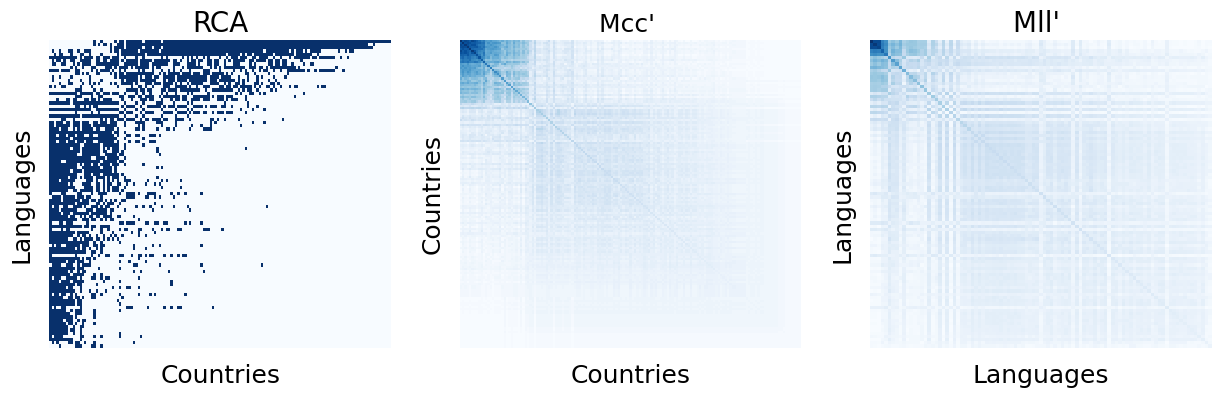

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
mcl_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[0])
mcc_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[1])
mll_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[2])

In [47]:
# complexity rankings

In [ ]:
# github space

In [80]:
# dataframe for regression
